# Tobin's Q - dataproject

In this project we will replicate the main analysis in our bachelor thesis "Tobin's Q - Quotable or Questionalble?". Buidling on the work of Blanchard, Rhee and Summers (1993) and looking at the U.S non-financial sector, we investigate whether mispricing in the financial markets has important implications for the real economy. In our bachelor thesis, we collected all the needed data from Federal Reserve Bank of St. Louis (FRED) manually and made computations in Excel. The focus of the project is to simplify this process massively by getting the data from FRED using an API, clean it and make computations in Python. 

The work builds on Tobin's q theory. Tobin's q is the market value of assets (MV) divided by the replacement cost of those assets (K), $ q = \frac{MV}{K} $ and is theoretically a predictor of investments: if q is above one, firms should increase their investments as the cost of aquiring new assets is lower than their value after installed in the firm. The q can be divided into the products of two terms where FV is fundamental value:


$$ q = \frac{MV}{FV}\frac{FV}{K} $$

The first term is the ratio of market value to fundamental value and can be interpreted as the degree of mispricing. The second term is fundamental q. We analyze if investments responds to changes in fundamental q, mispricing or both by regressing the ratio of investments (I) to the replacement cost of capital (K) allowing for both terms of q to enter seperately. We run our regressions using the first difference of the natural logarithm of the variables. We substitue $\frac{MV}{FV}$ with q. Hence our regression will look as follows:

$$ \Delta \ln\left(\frac{I}{K}\right) = \alpha + \delta_1\Delta \ln\left(\frac{MV}{FV}\frac{FV}{K}\right) + \delta_2\Delta \ln\left(\frac{FV}{K}\right) + \epsilon $$

$$ = \alpha + \delta_1\Delta \ln\left(\frac{MV}{FV}\right) + (\delta_1+\delta_2)\Delta \ln\left(\frac{FV}{K}\right) + \epsilon $$

Thus, the coefficient on q will capture the sensitivity of investment to misvaluation while the sum of the coefficient on q and $\frac{FV}{K}$ will capture the sensitivity of investment to changes in q not caused by misvaluation.

From here, the project will proceed as follows. First we will read the data for the construction of q and $\frac{I}{K}$ and compute them. Then we will read data for a proxy for $\frac{FV}{K}$ and compute the proxy. Then we will compare our variables with those found by Blanchard, Rhee and Summers (1993). Finally we will run our regression analysis. 

We run our regression on yearly data. Data from FRED is a mix of quaterly and yearly data and is reported in either million or billions of U.S dollars. Thus, we will make various convertions underway. 

In [3]:
#Set imports:
import numpy as np
import pandas as pd
import pandas_datareader #API used to retrieve data form FRED
import statsmodels.api as sm # used for linear regression


# Predefine options for plots:
import matplotlib.pyplot as plt
plt.rcParams.update({"axes.grid":True,"grid.color":"black","grid.alpha":"0.25","grid.linestyle":"--"})
plt.rcParams.update({'font.size': 14})

#Encoding dates in a python friendly to specify the length of the desired time period from FRED. 
import datetime
start = datetime.datetime(1952,1,1)
end = datetime.datetime(2020,12,31)


# Read, clean and compute: Q

In the following we will construct our meassure of q.

We estimate q as the sum of the market value of equity (MVE), the market of long term debt (MVLD), the market value of short term debt (MVSD) less the value of net non-interesting bearing assets (NETNONINA) divided by the replacement cost of capital (K):


$$q = \frac{MVE+MVSD+MVLD-NETNONINA}{K}$$

The intuition is as follows: Our q should meassure the market value of capital assets divided by the replacement cost of those same assets. The market value of assets is the market value of all assets owned by both equity holders and debt holders. To remove all market value not associated with capital assets, we substract from the total value of debt and equity the value of obligations to, and receivables on, outside stakeholders (NETNONINA). 

In the following code we will retreive and compute each component of q. Fred has a direct measure of MVE. We construct the measures of MVSD, MVLD, NETNONINA and K ourselves.

In the following code, we start out by getting the data for MVE.

In [2]:
#Get data (quaterly) for market value of equity (MVE):
MVE = pandas_datareader.data.DataReader(['NCBCEL'], 'fred', start, end)

#Rename columns for MVE:
columns_dict = {}
columns_dict['NCBCEL'] = 'MVE'
MVE.rename(columns=columns_dict, inplace = True)

#Show dataset:
MVE.head(4)

,MVE
DATE,
1952-01-01,151.463
1952-04-01,157.607
1952-07-01,156.907
1952-10-01,146.628


In following code will retrive data for the market value of short term debt and compute it. We assume that the market value of debt corrosponds to the book value of debt. We net out all short term interest bearing claims on the asset side from short term claims on the liability side to get the value of net short term debt. 

In [5]:
#Get data (quaterly) for short term debt (SD):
SD = pandas_datareader.data.DataReader(['CPLBSNNCB', 'BLNECLBSNNCB', 'OLALBSNNCB','TSDABSNNCB',
'BOGZ1FL103034000Q', 'SRPSABSNNCB', 'FDABSNNCB', 'TSABSNNCB', 'AGSEBSABSNNCB', 'CPABSNNCB' ], 'fred', start, end)

#Rename columns for short term debt
columns_dict['CPLBSNNCB'] = 'Commercial paper'
columns_dict['BLNECLBSNNCB'] = 'Bank loans'
columns_dict['OLALBSNNCB'] = 'Other loans and advances'
columns_dict['TSDABSNNCB'] = 'Time deposits'
columns_dict['BOGZ1FL103034000Q'] = 'Money market funds'
columns_dict['SRPSABSNNCB'] = 'Securitys RPs'
columns_dict['FDABSNNCB'] = 'Foreign deposits'
columns_dict['TSABSNNCB'] = 'Treasury securities'
columns_dict['AGSEBSABSNNCB'] = 'Agency- and GSE-backed securities'
columns_dict['CPABSNNCB'] = 'Commercial paper (asset)'
SD.rename(columns=columns_dict, inplace = True)


#Calculate MVSD and add to dataset (data is in billions of dollars except Money market funds that are in millions why we convert):
SD['MVSD'] = (SD['Commercial paper'] + SD['Bank loans'] + SD['Other loans and advances'] - SD['Time deposits'] 
              - SD['Money market funds']/1000 - SD['Securitys RPs'] - SD['Foreign deposits'] - SD['Treasury securities'] 
              - SD['Agency- and GSE-backed securities'] - SD['Commercial paper (asset)'])


#Show dataset:
SD.head(4)

,Commercial paper,Bank loans,Other loans and advances,Time deposits,Money market funds,Securitys RPs,Foreign deposits,Treasury securities,Agency- and GSE-backed securities,Commercial paper (asset),MVSD
DATE,,,,,,,,,,,
1952-01-01,0.328,21.916,3.265,0.9,0.0,0.0,0.084,17.862,0.0,0.138,6.525
1952-04-01,0.304,21.494,3.369,0.9,0.0,0.0,0.102,16.635,0.0,0.432,7.098
1952-07-01,0.346,21.955,3.506,0.9,0.0,0.0,0.098,17.018,0.0,0.411,7.380
1952-10-01,0.331,22.979,3.827,0.9,0.0,0.0,0.075,17.647,0.0,0.195,8.320


In following code will retrive data for the market value of long term debt and compute it. We net out all long term interest bearing claims on the asset side from long term claims on the liability side to get the book value of long term debt. We then convert the book value of long term debt (BVLD) to market value of long term (MVLD) debt by calculating the present value of the streams of coupon payments on the debt and the repayment of the principal a maturity. The principal equals BVLD and coupon payments are net interest paid (NIP) in the sector. We assume a constant maturity (t) of 10 years and use an average of Moody's AAA and BAA corporate bond yield as the discount factor (r). The discountfactor is multiplied by 0.5 and rasied to power of 2t as most U.S corportate bonds have coupon bonds semiannualy:

$$MVLD = \text(NIP) * \left(\frac{1}{r}-\frac{1}{r(1+0.5r)^{2t}}\right)+\frac{BVLD}{r(1+0.5r)^{2t}} $$


In [6]:
#Get data (monthly for BAA and AAA and quaterly for the rest) for long term debt (LD):
LD = pandas_datareader.data.DataReader(['CBLBSNNCB', 'MSLBSNNCB', 'MLBSNNCB', 'MABSNNCB', 'MSABSNNCB',
'BOGZ1FA106130003Q', 'BAA', 'AAA'], 'fred', start, end)

#Rename columns for long term debt:
columns_dict['CBLBSNNCB'] = 'Corporate bonds'
columns_dict['MSLBSNNCB'] = 'Municipal securities'
columns_dict['MLBSNNCB'] = 'Total mortgages'
columns_dict['MABSNNCB'] = 'Total mortgages (asset)'
columns_dict['MSABSNNCB'] = 'Municipal securities (asset)'
columns_dict['BOGZ1FA106130003Q'] = 'Net interest paid'
LD.rename(columns=columns_dict, inplace = True)

# Calculate average of BAA and AAA columns
LD['Average of BAA and AAA'] = LD[['BAA', 'AAA']].mean(axis=1)

# Create new column that is an average of current row and the following two rows of 'Average of BAA and AAA' (from monthly to quarterly average)
LD['Corporate bond yield'] = LD['Average of BAA and AAA'].rolling(window=3).mean().shift(-2)

# Remove columns 'BAA', 'AAA' and 'Average of BAA and AAA'
LD = LD.drop(['BAA', 'AAA', 'Average of BAA and AAA'], axis=1)

# Remove rows with months '02', '03', '05', '06', '08', '09', '11', '12' (only keep quarters. First quater is in 01, second quater in 04 and so fourth)
LD = LD[~LD.index.strftime('%m').isin(['02', '03', '05', '06', '08', '09', '11', '12'])]

#Calculate BVLD and add to dataset:
LD['BVLD'] = (LD['Corporate bonds'] + LD['Municipal securities'] + LD['Total mortgages'] - 
LD['Total mortgages (asset)'] - LD['Municipal securities (asset)'])

#Calculate MVLD and add to dataset (net interest paid are in millions of dollars and corporate bond yield is in percent why we convert):
LD['MVLD']= (  LD['Net interest paid']/1000*(1/(LD['Corporate bond yield']/100)-
 1/((LD['Corporate bond yield']/100)*(1+0.5*(LD['Corporate bond yield']/100))**20))+ 
 LD['BVLD']/((1+0.5*(LD['Corporate bond yield']/100))**20)  )

#Show dataset:
LD.head(4)


,Corporate bonds,Municipal securities,Total mortgages,Total mortgages (asset),Municipal securities (asset),Net interest paid,Corporate bond yield,BVLD,MVLD
DATE,,,,,,,,,
1952-01-01,40.873,0.0,13.385,0.027,0.825,1230.0,3.250000,53.406,49.117976
1952-04-01,42.343,0.0,13.260,0.028,0.488,1258.0,3.215000,55.087,50.729160
1952-07-01,43.470,0.0,13.251,0.029,0.578,1271.0,3.228333,56.114,51.525577
1952-10-01,44.497,0.0,13.464,0.030,0.813,1271.0,3.256667,57.118,52.124015


In the following code we will get data for net non-interest bearing assets and compute it. We substract non-interest bearing liabilities from non-interest bearing financial asset. In doing so, we get the book value of net non-interest bearing assets. We assume that the book value equals market value. 

In [7]:
#Get data (quarterly) for net non interest bearing assets (NONINA):
NONINA = pandas_datareader.data.DataReader(['NCBCDCA', 'CCABSNNCB', 'TRABSNNCB', 'BOGZ1FL103092105Q', 'BOGZ1FL103092305Q',
'BOGZ1FL103178005Q', 'TPLBSNNCB', 'BOGZ1FL103192305Q'], 'fred', start, end)

#Rename columns for NONINA:
columns_dict['NCBCDCA'] = 'Checkable deposits and Currency'
columns_dict['CCABSNNCB'] = 'Consumer credit'
columns_dict['TRABSNNCB'] = 'Trade receivables'
columns_dict['BOGZ1FL103092105Q'] = 'U.S DI abroad (equity)'
columns_dict['BOGZ1FL103092305Q'] = 'U.S DI abroad (debt)'
columns_dict['BOGZ1FL103178005Q'] = 'Total taxes payable'
columns_dict['TPLBSNNCB'] = 'Trade payables'
columns_dict['BOGZ1FL103192305Q'] = 'FDI in U.S (debt)'
NONINA.rename(columns=columns_dict, inplace = True)

#Calculate NETNONINA and add to dataset: 
NONINA['NETNONINA'] =( NONINA['Checkable deposits and Currency']+NONINA['Consumer credit']+NONINA['Trade receivables']+
NONINA['U.S DI abroad (equity)']/1000+ NONINA['U.S DI abroad (debt)']/1000-NONINA['Total taxes payable']/1000-
NONINA['Trade payables']-NONINA['FDI in U.S (debt)']/1000 )

#Show dataset:
NONINA.head(4)

,Checkable deposits and Currency,Consumer credit,Trade receivables,U.S DI abroad (equity),U.S DI abroad (debt),Total taxes payable,Trade payables,FDI in U.S (debt),NETNONINA
DATE,,,,,,,,,
1952-01-01,24.511,5.589,43.434,12442.0,503.0,18812.0,30.361,544.0,36.762
1952-04-01,25.850,6.144,42.254,13002.0,527.0,16610.0,28.227,558.0,42.382
1952-07-01,26.398,6.247,46.001,13289.0,538.0,17238.0,30.753,567.0,43.915
1952-10-01,26.641,7.051,45.866,13706.0,555.0,17381.0,33.077,579.0,42.782


In the following code we get the data for the replacement cost of capital and compute it. We compute is as the replacement cost of nonresidential structures, equipment and inventories. 

In [8]:
#Get data (quarterly) for replacement cost of capital (RCC)
RCC = pandas_datareader.data.DataReader(['RCSNNWMVBSNNCB', 'ESABSNNCB', 'IABSNNCB'], 'fred', start, end)

#Rename columns for RCC:
columns_dict['RCSNNWMVBSNNCB'] = 'Nonresidential structures'
columns_dict['ESABSNNCB'] = 'Equipment'
columns_dict['IABSNNCB'] = 'Inventories'
RCC.rename(columns=columns_dict, inplace = True)

#Calculate replacement cost of capital and add to dataset:
RCC['RCC'] = RCC['Nonresidential structures'] + RCC['Equipment'] + RCC['Inventories']

#Show dataset:
RCC.head(4)

,Nonresidential structures,Equipment,Inventories,RCC
DATE,,,,
1952-01-01,176.509,76.672,66.508,319.689
1952-04-01,178.269,78.341,65.384,321.994
1952-07-01,180.262,78.746,66.118,325.126
1952-10-01,183.054,79.669,66.688,329.411


We now have all the necessary variables to compute our q. In the following, we will collect the data into one dataset and calculate quaterly q. From here we calculate a yearly q by taking the average over four quarters.

In [9]:
#Construct new dataset with above calculated variables to compute Q:
Q = pd.concat([SD['MVSD'], LD['MVLD'], NONINA['NETNONINA'], RCC['RCC'], MVE['MVE']], axis=1)

#Calculate quaterly Q and add to dataframe:
Q['Q']= (Q['MVE'] + Q['MVSD'] + Q['MVLD']- Q['NETNONINA'])/Q['RCC']

#Create new column that is an average of current row and the following three rows of 'Q quaterly' (annual Q)
Q['Q'] = Q['Q'].rolling(window=4).mean().shift(-3)

# Remove rows with months '04', '07', '10' (keep only yearly q in 01)
Q = Q[~Q.index.strftime('%m').isin(['04', '07', '10'])]

#Show dataset:
Q.head(4)

,MVSD,MVLD,NETNONINA,RCC,MVE,Q
DATE,,,,,,
1952-01-01,6.525,49.117976,36.762,319.689,151.463,0.524433
1953-01-01,8.114,52.697554,43.741,332.418,143.052,0.454500
1954-01-01,7.694,58.177052,46.297,345.687,156.255,0.566100
1955-01-01,7.534,62.310738,54.021,355.903,202.122,0.661516


# Read, clean and compute: $\frac{I}{K}$

In the following code we will get the data for the investment rate and compute it. We compute it as gross fixed investments in equipment and nonresidential structures divided by the end of year replacement cost of capitcal computed above.

In [10]:
#Get data (quaterly) for investment intensity (I):
I = pandas_datareader.data.DataReader(['BOGZ1FA105013005Q', 'BOGZ1FA105013075Q'], 'fred', start, end)

#Rename columns for investment variables:
columns_dict['BOGZ1FA105013005Q'] = 'Gross fixed investments'
columns_dict['BOGZ1FA105013075Q'] = 'Gross fixed investments in interlectual property rights'
I.rename(columns=columns_dict, inplace = True)

#Add RCC to dataset from previous dataset:
I['RCC'] = RCC['RCC']

#Change REC to end of year value. (End of year value of REC (month 10) is now in the month 01)
I['RCC'] = I['RCC'].shift(-3)


#Create new column that is an average of current row and the following three rows of investment variables (annual value)
I['Gross fixed investments'] = I['Gross fixed investments'].rolling(window=4).mean().shift(-3)
I['Gross fixed investments in interlectual property rights'] = I['Gross fixed investments in interlectual property rights'].rolling(window=4).mean().shift(-3)

# Remove rows with months '04', '07', '10' (keep only yearly value in 01)
I = I[~I.index.strftime('%m').isin(['04', '07', '10'])]

#Calculate invenstment intensity and add to data set (Gross fixed investments is in millions why we convert):
I['I/K'] = (I['Gross fixed investments']-I['Gross fixed investments in interlectual property rights'])/1000/I['RCC']

#Show dataset:
I.head(4)

,Gross fixed investments,Gross fixed investments in interlectual property rights,RCC,I/K
DATE,,,,
1952-01-01,24259.25,2458.25,329.411,0.066182
1953-01-01,26769.25,3060.25,344.670,0.068788
1954-01-01,26507.25,3254.25,351.393,0.066174
1955-01-01,29205.25,3595.25,386.573,0.066249


# Read, clean and compute: $\frac{FV}{K}$ / $\frac{PI}{K}$

We construct a profit rate as a proxy for $\frac{FV}{K}$. It is computed as profits after tax, interest and depreciation divided by the end of year replacement cost of capital. We assume a depreciation rate of 0.08%.

In [11]:
#Get data (quarterly) for profit rate:
PI = pandas_datareader.data.DataReader(['A464RC1A027NBEA', 'BOGZ1FU106231005A', 'BOGZ1FA106130003Q'], 'fred', start, end)

#Rename columns for profit rate:
columns_dict['A464RC1A027NBEA'] = 'Profits before tax'
columns_dict['BOGZ1FU106231005A'] = 'Corporate taxes'
PI.rename(columns=columns_dict, inplace = True)

#Add RCC to dataset from previously:
PI['RCC'] = RCC['RCC']

#Change RCC to end of year value (End of year value of REC (month 10) is now in the month 01)
PI['RCC'] = PI['RCC'].shift(-3)

#Add net interest paid to dataset from previously:
PI['Net interest paid'] = LD['Net interest paid']

#Create new column that is an average of current row and the following three rows of 'Net interest paid' (annual value)
PI['Net interst paid'] = PI['Net interest paid'].rolling(window=4).mean().shift(-3)

# Remove rows with months '04', '07', '10' (keep only yearly value in 01)
PI = PI[~PI.index.strftime('%m').isin(['04', '07', '10'])]

#Calculate profit rate and add to data set (taxes and interests are in millions why we convert):
PI['PI/K'] = (PI['Profits before tax']-PI['Corporate taxes']/1000+PI['Net interst paid']/1000+PI['RCC']*0.08)/PI['RCC']

#Show dataset:
PI.head(4)

,Profits before tax,Corporate taxes,Net interest paid,RCC,Net interst paid,PI/K
DATE,,,,,,
1952-01-01,34.978,17677.0,1230.0,329.411,1257.50,0.136338
1953-01-01,36.504,18369.0,1279.0,344.670,1334.00,0.136486
1954-01-01,33.717,15528.0,1566.0,351.393,1650.50,0.136460
1955-01-01,43.753,20115.0,1696.0,386.573,1699.75,0.145545


# Analysis and conclusion

In the following we will start out by graphically comparing our variables with those found by Blanchard, Rhee and Summers (1993). Then we will run our regression. 

The data used by Blanchard, Rhee and Summers (1993) is located in the BRS data spreadsheet. 

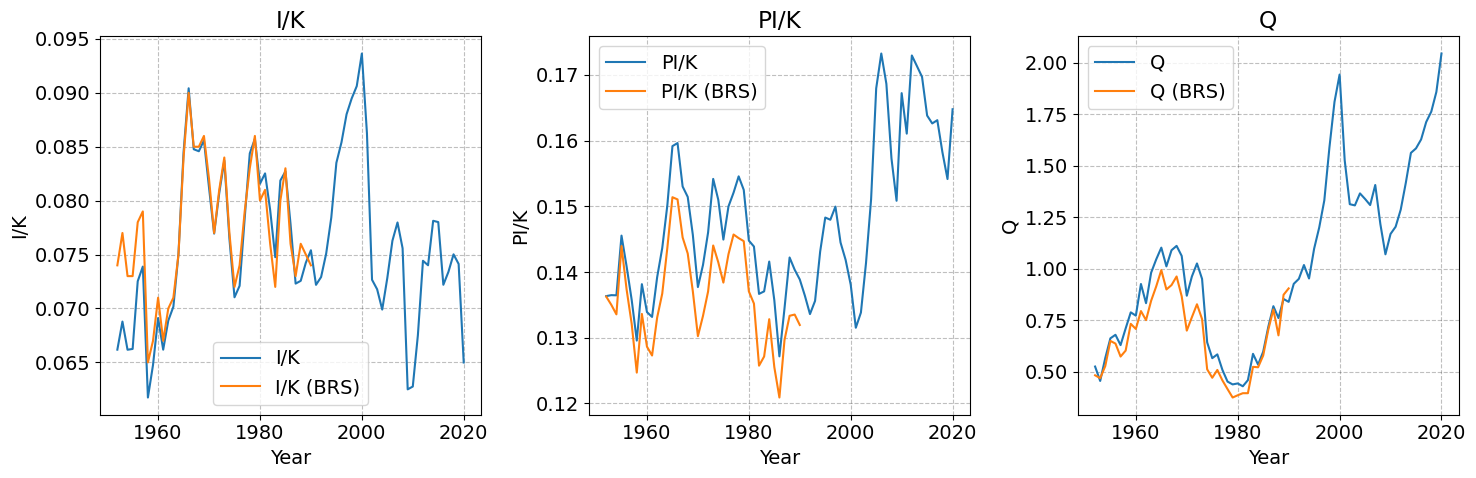

In [12]:
#Collect variables used for regression in a new dataset
Regression_variables = pd.concat([I['I/K'], PI['PI/K'], Q['Q'] ], axis=1)

#Add a Years column to dataset for merging with BRS data
Regression_variables['Years'] = Regression_variables.index.year

#Load in BRS data:
BRS = pd.read_excel('BRS data.xlsx')

#Merge BRS variables with own variables:
merged = pd.merge(BRS, Regression_variables, on='Years', how='outer')


#Plot our variables for comparison:

# Create subplots with 1 row and 3 columns
fig, axs = plt.subplots(1, 3, figsize=(15,5))

# Plot I/K on the first subplot
axs[0].plot(merged['Years'], merged['I/K'], label='I/K')
axs[0].plot(merged['Years'], merged['I/K (BRS)'], label='I/K (BRS)') # add BRS column
axs[0].set_title('I/K')
axs[0].set_xlabel('Year')
axs[0].set_ylabel('I/K')
axs[0].legend()

# Plot PI/K on the second subplot
axs[1].plot(merged['Years'], merged['PI/K'], label='PI/K')
axs[1].plot(merged['Years'], merged['PI/K (BRS)'], label='PI/K (BRS)') # add BRS column
axs[1].set_title('PI/K')
axs[1].set_xlabel('Year')
axs[1].set_ylabel('PI/K')
axs[1].legend()

# Plot Q on the third subplot
axs[2].plot(merged['Years'], merged['Q'], label='Q')
axs[2].plot(merged['Years'], merged['Q (BRS)'], label='Q (BRS)') # add BRS column
axs[2].set_title('Q')
axs[2].set_xlabel('Year')
axs[2].set_ylabel('Q')
axs[2].legend()

# Adjust spacing between subplots
fig.tight_layout()

# Display the figure
plt.show()


In the above we see that the dynamics between our variables and those found by Blanchard, Rhee and Summmers (1993) are similar. We suspect differences to arise from various data revisions since 1993. 

In the following we prepare our data for our regression. We regress the investment rate on q and the profitrate ($\pi$). Specifically, we will run the following regression:

$$ \Delta ln\left(\frac{I_t}{K_t}\right)=\alpha+\beta_1\Delta lnq_t+\beta_2\Delta lnq_{t-1}+\beta_3\Delta ln\pi_t+\beta_4\Delta ln\pi_{t-1}+\epsilon_t $$

In [13]:
#Create new data set with first difference logs of variables used for regression:
DlogRegression_variables =  Regression_variables.apply(lambda x: np.log(x).diff())

#Add lagged first differences of PI/K and Q:
DlogRegression_variables['PI/K_lag'] = DlogRegression_variables['PI/K'].shift(1)
DlogRegression_variables['Q_lag'] = DlogRegression_variables['Q'].shift(1) 

#Drop years coloumn
DlogRegression_variables = DlogRegression_variables.drop(columns='Years')

#Remove 1952 and 1953 only containing NaN's as a result of first differences and lagged first differences:
DlogRegression_variables = DlogRegression_variables.dropna()

#Show dataset for regressions:
DlogRegression_variables.head(4)

,I/K,PI/K,Q,PI/K_lag,Q_lag
DATE,,,,,
1954-01-01,-0.038738,-0.000193,0.219572,0.001081,-0.143118
1955-01-01,0.001133,0.064454,0.155763,-0.000193,0.219572
1956-01-01,0.090514,-0.032627,0.025642,0.064454,0.155763
1957-01-01,0.018591,-0.037004,-0.076724,-0.032627,0.025642


In the following we will run our regression

In [15]:
#Define variables for regression
X = sm.add_constant(DlogRegression_variables[['Q', 'Q_lag', 'PI/K', 'PI/K_lag' ]])
y = DlogRegression_variables['I/K']

# Fit the linear regression model using OLS
model = sm.OLS(y, X).fit()

# Print the regression summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    I/K   R-squared:                       0.445
Model:                            OLS   Adj. R-squared:                  0.410
Method:                 Least Squares   F-statistic:                     12.45
Date:                Tue, 11 Apr 2023   Prob (F-statistic):           1.71e-07
Time:                        18:31:38   Log-Likelihood:                 108.95
No. Observations:                  67   AIC:                            -207.9
Df Residuals:                      62   BIC:                            -196.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0072      0.006     -1.152      0.2

We summarize our results by simply adding up the coefficients (see introduction for intution). An increase in fundamental value of one percent leads to an increase in the investment rate of 1.21 percent (0.0254+0.1926+0.2948+0.7013), while an increase in misvaluation of one percent only leads to an increase in the investment rate of 0.22 percent (0.0254+0.1926).

Another way to state the result is that the elasticity of investment with respect to market valuation is more than 5 times higher when changes in market valuation reflect changed fundamentals, compared to when they do not.